In [1]:
import os
import glob
import numpy as np
from torch.utils.data import Dataset
import tifffile
import cv2
from tqdm import tqdm
import torch
import numpy as np
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.nn as nn
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torchvision.transforms.functional as TF
import torchvision.transforms as T

class RandomRotation90(nn.Module):
    """Randomly rotate image by 0, 90, 180, or 270 degrees."""
    def forward(self, img):
        angle = torch.randint(0, 4, (1,)).item() * 90
        return TF.rotate(img, angle)

class AddGaussianNoise(nn.Module):
    """Add Gaussian noise to the image tensor."""
    def __init__(self, mean=0.0, std=0.1):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, img):
        noise = torch.randn(img.shape, device=img.device, dtype=img.dtype) * self.std + self.mean
        return img + noise

class RandomCropTransform(nn.Module):
    """Random crop with specified output size."""
    def __init__(self, size):
        super().__init__()
        self.crop = T.RandomCrop(size)

    def forward(self, img):
        return self.crop(img)

class DropRandomChannels(nn.Module):
    """Randomly drop (zero out) channels from the tensor."""
    def __init__(self, p=0.4, min_keep=1):
        super().__init__()
        self.p = p
        self.min_keep = min_keep

    def forward(self, img):
        # img shape: [C, H, W] or [B, C, H, W]
        if img.dim() == 3:
            C = img.shape[0]
            n_drop = min(max(int(C * self.p), 0), C - self.min_keep)
            if n_drop > 0:
                # ❌ PROBLEM: randperm and mask created on CPU by default
                # ✅ FIX: Create on same device as img
                channels_to_drop = torch.randperm(C, device=img.device)[:n_drop]
                mask = torch.ones(C, device=img.device, dtype=img.dtype)
                mask[channels_to_drop] = 0
                img = img * mask.view(-1, 1, 1)
        elif img.dim() == 4:
            B, C = img.shape[:2]
            n_drop = min(max(int(C * self.p), 0), C - self.min_keep)
            if n_drop > 0:
                for b in range(B):
                    # ✅ FIX: Create on same device as img
                    channels_to_drop = torch.randperm(C, device=img.device)[:n_drop]
                    mask = torch.ones(C, device=img.device, dtype=img.dtype)
                    mask[channels_to_drop] = 0
                    img[b] = img[b] * mask.view(-1, 1, 1)
        return img

class SASSL(nn.Module):
    def __init__(self,random_crop_size = (32,32),drop_probability = 0.4 ,*args, **kwargs,):
        super().__init__(*args, **kwargs)

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        pretrained_model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

        # Create your models with 12 channels
        self.teacher = vit_b_16(weights=None)
        self.student = vit_b_16(weights=None)

        # 1. Modify first layer FIRST
        self.teacher.conv_proj = nn.Conv2d(12, 768, kernel_size=(16, 16), stride=(16, 16))
        self.student.conv_proj = nn.Conv2d(12, 768, kernel_size=(16, 16), stride=(16, 16))

        # 2. Remove classification heads BEFORE loading weights
        self.teacher.heads = nn.Identity()
        self.student.heads = nn.Identity()

        # 3. NOW copy pretrained weights (excluding conv_proj and heads)
        pretrained_dict = pretrained_model.state_dict()
        teacher_dict = self.teacher.state_dict()

        # Filter out conv_proj AND heads weights
        pretrained_dict = {k: v for k, v in pretrained_dict.items()
                           if k in teacher_dict and 'conv_proj' not in k and 'heads' not in k}

        self.teacher.load_state_dict(pretrained_dict, strict=False)
        self.student.load_state_dict(pretrained_dict, strict=False)

        self.teacher = self.teacher.to(self.device)
        self.student = self.student.to(self.device)

        self.n_local = 4
        for param in self.teacher.parameters():
            param.requires_grad = False
        self.teacher.eval()

        self.regular_augment = T.Compose([
            RandomRotation90(),
            AddGaussianNoise(mean=0.0, std=0.1),
            T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),
        ])

        self.random_crop = T.Compose([RandomCropTransform(size=random_crop_size),T.Resize((224, 224))])
        self.drop_random_channels = T.Compose([DropRandomChannels( p= drop_probability, min_keep=1)])
        self.resize_img = T.Resize((224, 224))

    def generate_views(self, image):
        # Global view (original size)

        image = image.to(self.device)
        image = self.resize_img(image)
        image = self.regular_augment(image)
        global_view = image

        # Local views (smaller crops)
        local_views = [self.random_crop(image) for _ in range(self.n_local)]

        # Spectral-aware view
        spectral_view = self.drop_random_channels(image)

        return global_view, local_views, spectral_view

    def forward(self, image):
        global_view, local_views, spectral_view = self.generate_views(image)

        # Teacher processes only global view
        with torch.no_grad():
            teacher_output = self.teacher(global_view)

        # Student processes local and spectral views
        student_outputs = []
        for local_view in local_views:
            student_outputs.append(self.student(local_view))
        student_outputs.append(self.student(spectral_view))
        return teacher_output, student_outputs

    @torch.no_grad()
    def update_teacher(self, momentum=0.996):
        """Update teacher parameters with EMA of student parameters."""
        for teacher_param, student_param in zip(
            self.teacher.parameters(),
            self.student.parameters()
        ):
            # In-place operations (more efficient and ensures device consistency)
            teacher_param.data.mul_(momentum).add_(student_param.data, alpha=1 - momentum)

In [4]:
class ClassificationDataset(Dataset):
    """Dataset for Sentinel-2 multi-spectral inpainting"""

    def __init__(self, root_dir, mask_type='random', augment=False, target_size=None):
        """
        Args:
            root_dir: Path to s2a folder (e.g., 'D:/s2a')
            mask_type: 'random', 'center', or 'irregular'
            augment: Apply random flips/rotations
            target_size: (H, W) to resize all images, or None to use 10m resolution
        """
        self.root_dir = root_dir
        self.mask_type = mask_type
        self.augment = augment
        self.target_size = target_size

        # Band names in order (12 bands total)
        self.bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

        # Band resolutions (in meters)
        self.band_resolutions = {
            'B1': 60, 'B2': 10, 'B3': 10, 'B4': 10,
            'B5': 20, 'B6': 20, 'B7': 20, 'B8': 10,
            'B8A': 20, 'B9': 60, 'B11': 20, 'B12': 20
        }

        # Find all timestamped folders
        self.samples = []
        self.labels = []  # Store labels separately for fast access

        for region_folder in tqdm(glob.glob(os.path.join(root_dir, '*'))):
            if os.path.isdir(region_folder):
                if(region_folder[-3:] == "RPH"): label = "RPH"
                elif(region_folder[-5:] == "Blast"): label = "Blast"
                elif(region_folder[-4:] == "Rust"): label = "Rust"
                elif(region_folder[-5:] == "Aphid"): label = "Aphid"
                else: continue

                for timestamp_folder in glob.glob(os.path.join(region_folder, '*')):
                    if os.path.isdir(timestamp_folder):
                        # Check if all bands exist
                        band_paths = {band: os.path.join(timestamp_folder, f'{band}.tif')
                                     for band in self.bands}
                        if all(os.path.exists(p) for p in band_paths.values()):
                            self.samples.append(band_paths)
                            # Convert label to integer immediately
                            if(label == "RPH"): label_int = 0
                            elif(label == "Blast"): label_int = 1
                            elif(label == "Rust"): label_int = 2
                            elif(label == "Aphid"): label_int = 3
                            self.labels.append(label_int)

        print(f"Found {len(self.samples)} samples with all 12 bands")

    def __len__(self):
        return len(self.samples)

    def resize_band(self, band_data, target_shape):
        """Resize a band to target shape using bilinear interpolation"""
        if band_data.shape == target_shape:
            return band_data

        # Use OpenCV for faster resizing
        resized = cv2.resize(
            band_data,
            (target_shape[1], target_shape[0]),  # OpenCV uses (W, H)
            interpolation=cv2.INTER_LINEAR
        )
        return resized

    def load_multispectral_image(self, band_paths):
        """Load all 12 bands and stack them with consistent resolution"""
        bands_data = []
        shapes = []

        # First pass: load all bands and record shapes
        loaded_bands = {}
        for band in self.bands:
            img = tifffile.imread(band_paths[band])
            loaded_bands[band] = img
            shapes.append(img.shape)

        # Determine target shape
        if self.target_size is not None:
            target_shape = self.target_size
        else:
            # Use the shape of 10m bands (B2, B3, B4, B8) as reference
            # These are typically the largest
            reference_band = loaded_bands['B4']  # 10m band
            target_shape = reference_band.shape

        # Second pass: resize all bands to target shape
        for band in self.bands:
            img = loaded_bands[band]

            # Resize if needed
            if img.shape != target_shape:
                img = self.resize_band(img, target_shape)

            bands_data.append(img)

        # Stack along channel dimension: (12, H, W)
        multi_band = np.stack(bands_data, axis=0)
        return multi_band

    def normalize_sentinel2(self, img):
        """
        Normalize Sentinel-2 data to [0, 1]
        Sentinel-2 L1C has typical range 0-10000 (reflectance * 10000)
        """
        # Clip extreme values and normalize
        img = np.clip(img, 0, 10000)
        img = img.astype(np.float32) / 10000.0
        return img

    def create_random_mask(self, shape, num_masks=None):
        """Create random rectangular mask(s)"""
        C, H, W = shape
        mask = np.ones((C, H, W), dtype=np.float32)

        if num_masks is None:
            num_masks = np.random.randint(1, 4)

        for _ in range(num_masks):
            mask_h = np.random.randint(32, min(128, H // 2))
            mask_w = np.random.randint(32, min(128, W // 2))

            top = np.random.randint(0, H - mask_h)
            left = np.random.randint(0, W - mask_w)

            # Mask all channels
            mask[:, top:top+mask_h, left:left+mask_w] = 0

        return mask

    def create_center_mask(self, shape, mask_ratio=0.25):
        """Create centered square mask"""
        C, H, W = shape
        mask = np.ones((C, H, W), dtype=np.float32)

        mask_size = int(min(H, W) * mask_ratio)
        top = (H - mask_size) // 2
        left = (W - mask_size) // 2

        mask[:, top:top+mask_size, left:left+mask_size] = 0
        return mask

    def augment_data(self, img):
        """Random flips and rotations"""
        # Random horizontal flip
        if np.random.random() > 0.5:
            img = np.flip(img, axis=2).copy()

        # Random vertical flip
        if np.random.random() > 0.5:
            img = np.flip(img, axis=1).copy()

        # Random 90 degree rotations
        k = np.random.randint(0, 4)
        if k > 0:
            img = np.rot90(img, k, axes=(1, 2)).copy()

        return img

    def __getitem__(self, idx):
        # Load all 12 bands
        band_paths = self.samples[idx]
        img = self.load_multispectral_image(band_paths)

        # Normalize
        img = self.normalize_sentinel2(img)

        # Augmentation
        if self.augment:
            img = self.augment_data(img)

        # Get pre-computed label
        label = self.labels[idx]

        return {
            'original': img,
            'label' : label
        }

In [5]:
encoder_path = "/content/drive/MyDrive/cv-contest/SASSL_checkpoints/sassl_checkpoint_epoch_50.pth"
checkpoint = torch.load(encoder_path, map_location='cuda')
sassl = SASSL()
sassl.teacher.load_state_dict(checkpoint["teacher_state_dict"])
print(f"✓ Loaded encoder from {encoder_path}")

sassl.teacher.eval()

✓ Loaded encoder from /content/drive/MyDrive/cv-contest/SASSL_checkpoints/sassl_checkpoint_epoch_50.pth


VisionTransformer(
  (conv_proj): Conv2d(12, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_

In [6]:
import numpy as np
from torch.utils.data import Subset, DataLoader

def create_balanced_split(dataset, val_samples_per_class=20, max_train_per_class=100):
    """
    Create balanced train/val split with fixed number of samples per class

    Args:
        dataset: Your ClassificationDataset
        val_samples_per_class: Number of samples per class for validation
        max_train_per_class: Maximum number of samples per class for training

    Returns:
        train_indices, val_indices
    """
    # Get all labels
    all_labels = np.array(dataset.labels)

    # Get indices for each class
    class_indices = {
        0: np.where(all_labels == 0)[0],  # RPH
        1: np.where(all_labels == 1)[0],  # Blast
        2: np.where(all_labels == 2)[0],  # Rust
        3: np.where(all_labels == 3)[0],  # Aphid
    }

    # Print original class distribution
    print("Original class distribution:")
    class_names = ['RPH', 'Blast', 'Rust', 'Aphid']
    for cls_id, indices in class_indices.items():
        print(f"  {class_names[cls_id]}: {len(indices)} samples")

    train_indices = []
    val_indices = []

    print(f"\nSplitting with {val_samples_per_class} val and max {max_train_per_class} train per class:")

    # For each class, split into train/val
    print('create_balanced_split: For each class, split into train/val')
    for cls_id, indices in tqdm(class_indices.items()):
        # Shuffle indices for this class
        np.random.seed(42)  # For reproducibility
        shuffled = indices.copy()
        np.random.shuffle(shuffled)

        # Take first val_samples_per_class for validation
        val_idx = shuffled[:val_samples_per_class]

        # Take next max_train_per_class for training (limit to max)
        remaining = shuffled[val_samples_per_class:]
        train_idx = remaining[:max_train_per_class]

        # Calculate how many were left out
        left_out = len(remaining) - len(train_idx)

        val_indices.extend(val_idx)
        train_indices.extend(train_idx)

        print(f"  {class_names[cls_id]}: {len(train_idx)} train, {len(val_idx)} val, {left_out} left out")

    # Shuffle the final indices
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    print(f"\nFinal counts:")
    print(f"  Training: {len(train_indices)} samples")
    print(f"  Validation: {len(val_indices)} samples")
    print(f"  Total used: {len(train_indices) + len(val_indices)} / {len(dataset)}")

    return train_indices, val_indices


# Create dataset
cdata = ClassificationDataset(
    root_dir="/content/drive/MyDrive/cv-contest/kaggle",
    mask_type='random',
    augment=True,
    target_size=(256, 256)
)

# Create balanced split with limits
train_indices, val_indices = create_balanced_split(
    cdata,
    val_samples_per_class=20,
    max_train_per_class=100  # Limit to 100 training samples per class
)

# Create Subset datasets
train_dataset = Subset(cdata, train_indices)
val_dataset = Subset(cdata, val_indices)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
)
print(f"Train batches: {len(train_loader)}")

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
)

print(f"Val batches: {len(val_loader)}")

print(f"\nDataLoaders created successfully!")

100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Found 900 samples with all 12 bands
Original class distribution:
  RPH: 495 samples
  Blast: 75 samples
  Rust: 40 samples
  Aphid: 290 samples

Splitting with 20 val and max 100 train per class:
create_balanced_split: For each class, split into train/val


100%|██████████| 4/4 [00:00<00:00, 10713.42it/s]

  RPH: 100 train, 20 val, 375 left out
  Blast: 55 train, 20 val, 0 left out
  Rust: 20 train, 20 val, 0 left out
  Aphid: 100 train, 20 val, 170 left out

Final counts:
  Training: 275 samples
  Validation: 80 samples
  Total used: 355 / 900
Train batches: 35
Val batches: 10

DataLoaders created successfully!


In [7]:
batch_outputs = []
batch_labels = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

for batch in tqdm(val_loader):
    images = batch['original'].to(device)
    teacher_outputs, _ = sassl(images)
    batch_outputs.append(teacher_outputs.cpu().numpy())

    labels = batch['label'].to('cpu')
    batch_labels.append(labels)

100%|██████████| 10/10 [03:53<00:00, 23.37s/it]


In [14]:
from sklearn.decomposition import PCA

# flatten the batch-wise python array of np arrays into a single np array
val_outputs = np.concatenate(batch_outputs)
val_labels = np.concatenate(batch_labels)

print(val_outputs.shape)
print(val_labels.shape)

# do pca on val_output
pca = PCA(n_components=8)
pca_outputs = pca.fit_transform(val_outputs)

(80, 768)
(80,)


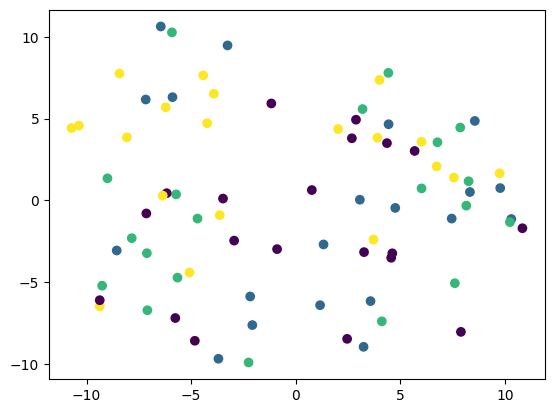

In [15]:
# visualize the two most variant dimensions
import matplotlib.pyplot as plt

plt.scatter(pca_outputs[:, 0], pca_outputs[:, 1], c=val_labels)

In [16]:
print("Explained Variance Ratio for each Principal Component:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"  Principal Component {i+1}: {ratio:.2%} of variance explained")

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"\nCumulative Explained Variance:")
for i, cum_ratio in enumerate(cumulative_variance):
    print(f"  Up to Principal Component {i+1}: {cum_ratio:.2%}")

Explained Variance Ratio for each Principal Component:
  Principal Component 1: 21.47% of variance explained
  Principal Component 2: 14.54% of variance explained
  Principal Component 3: 13.44% of variance explained
  Principal Component 4: 10.18% of variance explained
  Principal Component 5: 8.60% of variance explained
  Principal Component 6: 6.02% of variance explained
  Principal Component 7: 4.54% of variance explained
  Principal Component 8: 3.72% of variance explained

Cumulative Explained Variance:
  Up to Principal Component 1: 21.47%
  Up to Principal Component 2: 36.01%
  Up to Principal Component 3: 49.44%
  Up to Principal Component 4: 59.62%
  Up to Principal Component 5: 68.22%
  Up to Principal Component 6: 74.25%
  Up to Principal Component 7: 78.78%
  Up to Principal Component 8: 82.51%
